In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from helpers import get_Xy
from termcolor import colored
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf

import numpy as np

Using same seed to reapet all experemetns with same results.

In [9]:
seed = 1

np.random.seed(seed)
tf.random.set_seed(seed)

## Load data

In [10]:
import pickle
with open("sent.pkl", 'rb') as f:
    X_train_list, X_test_list, y_train_list, y_test_list = pickle.load(f)

# Classification

Creating smaller matrices for sequence labeling.

E.g data matrix contains 408 sentences. Let *time_steps* = 50.
This function creates 5 matrices with 50 embedded sentences. The last matrix will contain 8 vectors with information and 42 vectors with zeros.

*masks* contains vectors with True (if vector with useful information) and False (vector contains zeros).

In [11]:
def create_rec_data_from_long_matrix(x, y, time_steps, features):
    x_recs = []
    y_recs = []
    masks = []
    i = 0
    while i * time_steps < len(x):
        x_rec = np.zeros(dtype=np.float32, shape=(time_steps, features))
        y_rec = np.zeros(dtype=np.float32, shape=(time_steps,))
        mask = np.full(fill_value=False, dtype=np.bool, shape=(time_steps,))

        length = min([time_steps, len(x) - i * time_steps])
        x_rec[:length, :] = x[i*time_steps:i*time_steps + length, :]
        y_rec[:length] = y[i*time_steps:i*time_steps + length]
        mask[:length] = True
        i += 1
        x_recs.append(x_rec)
        y_recs.append(y_rec)
        masks.append(mask)
    
    return x_recs, y_recs, masks

Checking that function above works fine with 18 sentences and 5 time steps.

In [12]:
time_steps = 5
features = 1
x = np.arange(18).reshape(-1, 1)
y = np.arange(18)
x_recs, y_recs, masks = create_rec_data_from_long_matrix(x, y, time_steps, features)
x_recs, y_recs, masks

([array([[0.],
         [1.],
         [2.],
         [3.],
         [4.]], dtype=float32),
  array([[5.],
         [6.],
         [7.],
         [8.],
         [9.]], dtype=float32),
  array([[10.],
         [11.],
         [12.],
         [13.],
         [14.]], dtype=float32),
  array([[15.],
         [16.],
         [17.],
         [ 0.],
         [ 0.]], dtype=float32)],
 [array([0., 1., 2., 3., 4.], dtype=float32),
  array([5., 6., 7., 8., 9.], dtype=float32),
  array([10., 11., 12., 13., 14.], dtype=float32),
  array([15., 16., 17.,  0.,  0.], dtype=float32)],
 [array([ True,  True,  True,  True,  True]),
  array([ True,  True,  True,  True,  True]),
  array([ True,  True,  True,  True,  True]),
  array([ True,  True,  True, False, False])])

Creating recurrent data for all matrices.

In [13]:
def create_rec_data(X_list, y_list, time_steps):
    X_rec = []
    Y_rec = []
    mask_rec = []
    
    features = X_list[0].shape[1]
    
    for x, y in zip(X_list, y_list):
        i = 0
        x_recs, y_recs, masks = create_rec_data_from_long_matrix(x, y, time_steps, features)
        X_rec.extend(x_recs)
        Y_rec.extend(y_recs)
        mask_rec.extend(masks)
    X_rec = np.stack(X_rec)         
    Y_rec = np.stack(Y_rec)
    mask_rec = np.stack(mask_rec)
    return X_rec, Y_rec, mask_rec

X_train_rec, y_train_rec, mask_train_rec = create_rec_data(X_train_list, y_train_list, 50)
X_test_rec, y_test_rec, mask_test_rec = create_rec_data(X_test_list, y_test_list, 50)

Checking shapes

In [14]:
y_train_rec = y_train_rec[:, :, None]
y_test_rec = y_test_rec[:, :, None]

print(X_train_rec.shape, y_train_rec.shape, mask_train_rec.shape)
print(X_test_rec.shape, y_test_rec.shape, mask_test_rec.shape)

(393, 50, 100) (393, 50, 1) (393, 50)
(158, 50, 100) (158, 50, 1) (158, 50)


In [15]:
max_sent = 50
features = 100

In [16]:
import tensorflow as tf

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dropout, Bidirectional, TimeDistributed, GRU, Dense
from tensorflow.keras.metrics import Precision, Recall

In [17]:
metrics=[Precision(), Recall()]

Creating RNN with one recurrent bi-GRU layer and one hidden dense layer. As metrics using recall and precition.

In [18]:
np.random.seed(seed)
tf.random.set_seed(seed)

input = Input(shape=(max_sent, features))
model = Dropout(0.4)(input)
model = Bidirectional(GRU(units=200, return_sequences=True, recurrent_dropout=0.1))(model) 
model = Dropout(0.4)(model)
model = TimeDistributed(Dense(100, activation="sigmoid"))(model) 
model = Dropout(0.4)(model)
out = TimeDistributed(Dense(1, activation="sigmoid"))(model)  

model = Model(input, out)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=metrics)

Saving model weight after each epoch.

In [19]:
from os.path import exists, join
from os import mkdir

weight_dir = 'weights'
checkpoint_filepath = join(weight_dir, 'saved-weight-{epoch:02d}.hdf5')

if not exists(weight_dir):
    mkdir(weight_dir)

saver_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only=False,
    save_freq=1)

history = model.fit(X_train_rec, y_train_rec, batch_size=50, epochs=200, callbacks=[saver_callback], validation_data=(X_test_rec, y_test_rec))

Epoch 1/200
8/8 [==============================] - 5s 620ms/step - loss: 0.6294 - precision: 0.0474 - recall: 0.3092 - val_loss: 0.2773 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/200
8/8 [==============================] - 4s 504ms/step - loss: 0.2663 - precision: 0.0196 - recall: 9.6618e-04 - val_loss: 0.2714 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/200
8/8 [==============================] - 4s 468ms/step - loss: 0.2637 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.2152 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/200
8/8 [==============================] - 5s 571ms/step - loss: 0.2186 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.2045 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/200
8/8 [==============================] - 5s 602ms/step - loss: 0.2212 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.2005 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/200
8/8 [==========

Epoch 45/200
8/8 [==============================] - 4s 488ms/step - loss: 0.1004 - precision: 0.7373 - recall: 0.5614 - val_loss: 0.1093 - val_precision: 0.6848 - val_recall: 0.3198
Epoch 46/200
8/8 [==============================] - 4s 479ms/step - loss: 0.0850 - precision: 0.7965 - recall: 0.5671 - val_loss: 0.1057 - val_precision: 0.7000 - val_recall: 0.3553
Epoch 47/200
8/8 [==============================] - 4s 479ms/step - loss: 0.0918 - precision: 0.7627 - recall: 0.5652 - val_loss: 0.1071 - val_precision: 0.6984 - val_recall: 0.3350
Epoch 48/200
8/8 [==============================] - 4s 489ms/step - loss: 0.0840 - precision: 0.7948 - recall: 0.5874 - val_loss: 0.1055 - val_precision: 0.7035 - val_recall: 0.3553
Epoch 49/200
8/8 [==============================] - 4s 484ms/step - loss: 0.0846 - precision: 0.8116 - recall: 0.6077 - val_loss: 0.1046 - val_precision: 0.7048 - val_recall: 0.3756
Epoch 50/200
8/8 [==============================] - 4s 479ms/step - loss: 0.0918 - precisi

8/8 [==============================] - 4s 486ms/step - loss: 0.0781 - precision: 0.8287 - recall: 0.6077 - val_loss: 0.1188 - val_precision: 0.7500 - val_recall: 0.3198
Epoch 91/200
8/8 [==============================] - 4s 479ms/step - loss: 0.0790 - precision: 0.7651 - recall: 0.7237 - val_loss: 0.1229 - val_precision: 0.7429 - val_recall: 0.2640
Epoch 92/200
8/8 [==============================] - 4s 516ms/step - loss: 0.0790 - precision: 0.8336 - recall: 0.6193 - val_loss: 0.1023 - val_precision: 0.6893 - val_recall: 0.4898
Epoch 93/200
8/8 [==============================] - 4s 450ms/step - loss: 0.0761 - precision: 0.8344 - recall: 0.6522 - val_loss: 0.1226 - val_precision: 0.6954 - val_recall: 0.2665
Epoch 94/200
8/8 [==============================] - 3s 436ms/step - loss: 0.0723 - precision: 0.8071 - recall: 0.6348 - val_loss: 0.1062 - val_precision: 0.6798 - val_recall: 0.4365
Epoch 95/200
8/8 [==============================] - 4s 449ms/step - loss: 0.0693 - precision: 0.8205 - 

Epoch 135/200
8/8 [==============================] - 5s 618ms/step - loss: 0.0481 - precision: 0.8130 - recall: 0.8193 - val_loss: 0.1935 - val_precision: 0.6226 - val_recall: 0.0838
Epoch 136/200
8/8 [==============================] - 4s 472ms/step - loss: 0.0582 - precision: 0.8030 - recall: 0.7836 - val_loss: 0.1342 - val_precision: 0.6212 - val_recall: 0.3122
Epoch 137/200
8/8 [==============================] - 4s 445ms/step - loss: 0.0521 - precision: 0.8691 - recall: 0.7314 - val_loss: 0.1216 - val_precision: 0.6496 - val_recall: 0.3858
Epoch 138/200
8/8 [==============================] - 4s 484ms/step - loss: 0.0583 - precision: 0.8456 - recall: 0.7565 - val_loss: 0.1437 - val_precision: 0.7055 - val_recall: 0.2614
Epoch 139/200
8/8 [==============================] - 4s 483ms/step - loss: 0.0519 - precision: 0.7996 - recall: 0.8213 - val_loss: 0.1085 - val_precision: 0.6807 - val_recall: 0.4112
Epoch 140/200
8/8 [==============================] - 4s 494ms/step - loss: 0.0428 - p

Epoch 180/200
8/8 [==============================] - 4s 484ms/step - loss: 0.0296 - precision: 0.9005 - recall: 0.8744 - val_loss: 0.1642 - val_precision: 0.6779 - val_recall: 0.2563
Epoch 181/200
8/8 [==============================] - 4s 478ms/step - loss: 0.0307 - precision: 0.9240 - recall: 0.8570 - val_loss: 0.1439 - val_precision: 0.6233 - val_recall: 0.3401
Epoch 182/200
8/8 [==============================] - 4s 471ms/step - loss: 0.0347 - precision: 0.8483 - recall: 0.9130 - val_loss: 0.1967 - val_precision: 0.7083 - val_recall: 0.1726
Epoch 183/200
8/8 [==============================] - 4s 515ms/step - loss: 0.0301 - precision: 0.9421 - recall: 0.8483 - val_loss: 0.1554 - val_precision: 0.6354 - val_recall: 0.3096
Epoch 184/200
8/8 [==============================] - 4s 487ms/step - loss: 0.0297 - precision: 0.8885 - recall: 0.8928 - val_loss: 0.1506 - val_precision: 0.6739 - val_recall: 0.3147
Epoch 185/200
8/8 [==============================] - 4s 515ms/step - loss: 0.0281 - p

Checking overfitting and learning curve.

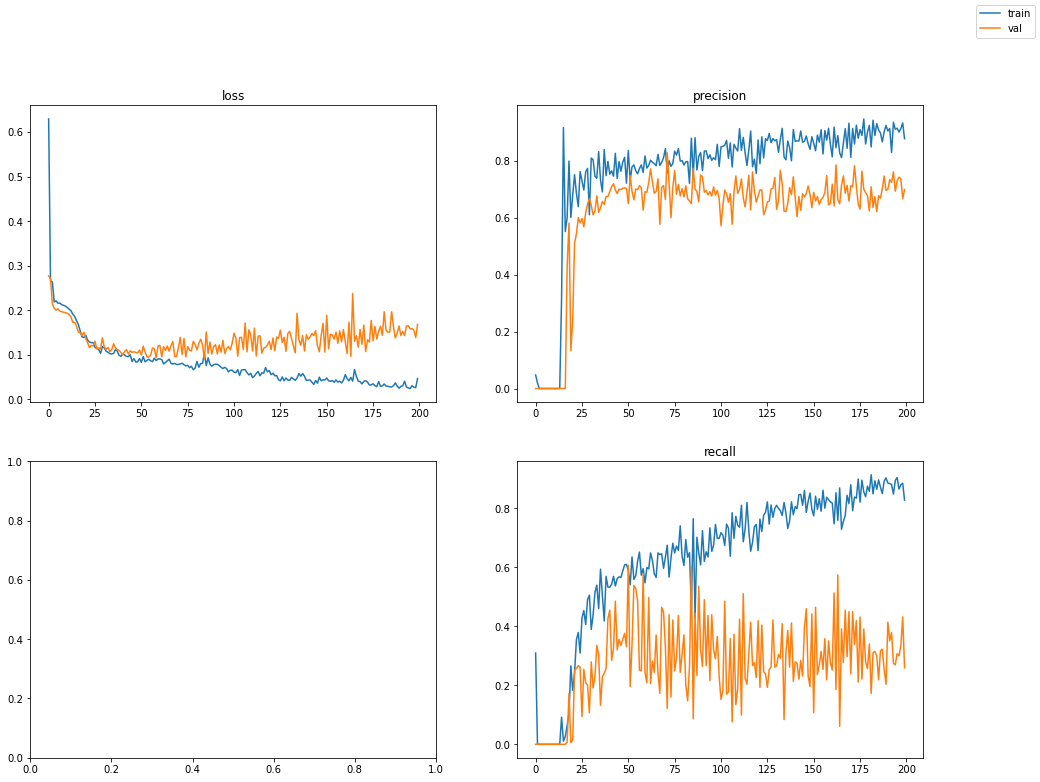

In [40]:
import matplotlib.pyplot as plt



def plot_loss_precision_recall(loss, val_loss, precision, val_precision, recall, val_recall):
    fig, ax = plt.subplots(2, 2, figsize=(16, 12))

    ax[0, 0].plot(loss, label='train')
    ax[0, 0].plot(val_loss, label='val')
    ax[0, 0].set_title("loss")

    ax[0, 1].set_title("precision")
    ax[0, 1].plot(precision)
    ax[0, 1].plot(val_precision)

    ax[1, 1].set_title("recall")
    ax[1, 1].plot(recall)
    ax[1, 1].plot(val_recall)


    fig.legend()
    plt.show()
    
plot_loss_precision_recall(history.history['loss'], history.history['val_loss'], 
                           history.history['precision'], history.history['val_precision'], 
                           history.history['recall'], history.history['val_recall'])

Recall and loss growing till 50 epoch. After that there is overfitting. Let's choose the model before overfitting.

In [22]:
best_epoch = 50
model.load_weights(checkpoint_filepath.format(epoch=best_epoch))

In [23]:
y_pred_probs = model.predict(X_test_rec)

Making flat list from recurrent data to count metrix.

In [28]:
def make_flat(y_times, mask):
    y_flat = []

    for ys, ms in zip(y_times, mask):
        for y, m in zip(ys, ms):
            if m:
                y_flat.append(y)
    return np.array(y_flat)

y_pred_probs_flat = make_flat(y_pred_probs, mask_test_rec) 
y_flat_true = make_flat(y_test_rec, mask_test_rec)

In [29]:
y_pred_probs_flat.shape, y_flat_true.shape

((7557, 1), (7557, 1))

Counting precision and recall for different thresholds.

In [30]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_flat_true, y_pred_probs_flat)

c:\users\roman\appdata\local\conda\conda\envs\tfft\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


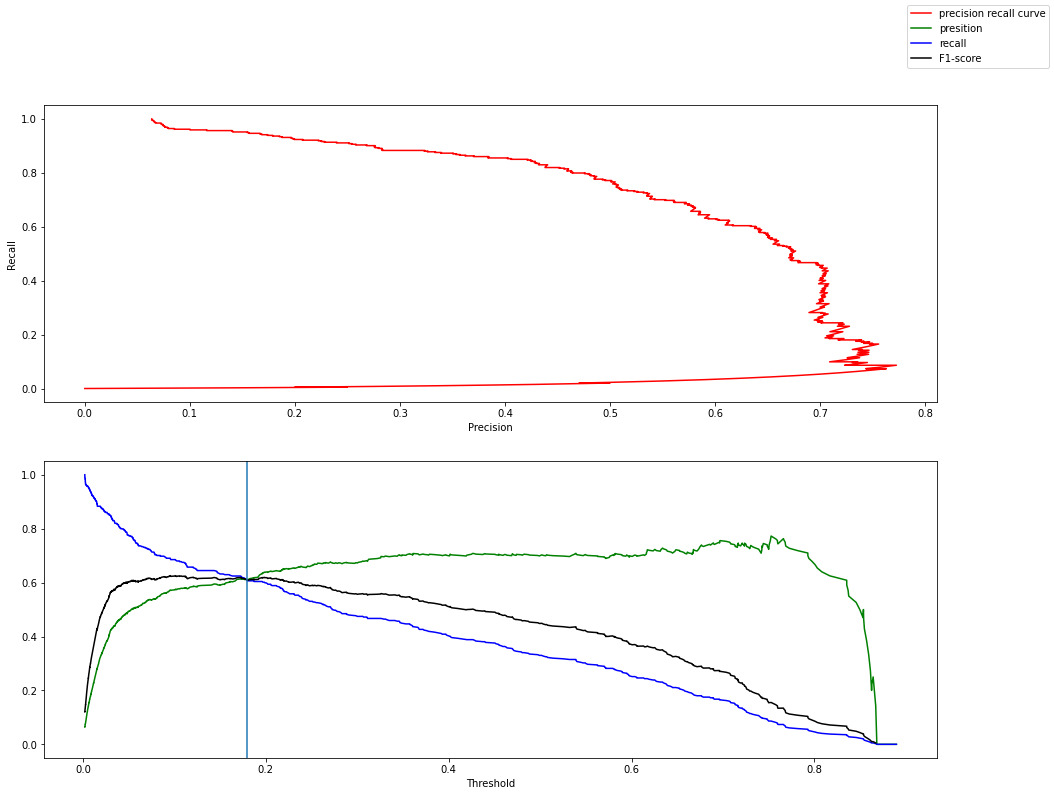

In [36]:
fig, ax = plt.subplots(2, 1, figsize=(16, 12))

ax[0].plot(precisions[:-1], recalls[:-1], color='red', label='precision recall curve')
ax[0].set_xlabel("Precision")
ax[0].set_ylabel("Recall")

ax[1].plot(thresholds, precisions[:-1], color='green', label='presition')
ax[1].plot(thresholds, recalls[:-1],  color='blue',label='recall')
ax[1].plot(thresholds, 2*recalls[:-1]*precisions[:-1]/(recalls[:-1]+precisions[:-1]),  color='black',label='F1-score')
ax[1].axvline(x=0.18)
ax[1].set_xlabel("Threshold")

fig.legend()
plt.show()

Best tradeoff between recall and precision is around 0.18

In [37]:
y_flat_pred = np.zeros_like(y_pred_probs_flat)
y_flat_pred[y_pred_probs_flat >= 0.18] = 1

Printing metrix.

In [38]:
print(f1_score(y_flat_true, y_flat_pred))
print(classification_report(y_flat_true, y_flat_pred))
print(confusion_matrix(y_flat_true, y_flat_pred))

0.6089171974522293
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      7163
         1.0       0.61      0.61      0.61       394

    accuracy                           0.96      7557
   macro avg       0.79      0.79      0.79      7557
weighted avg       0.96      0.96      0.96      7557

[[7011  152]
 [ 155  239]]
